In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
import plotly.express as px
import plotly.graph_objects as go
from glob import glob

In [51]:
def wrangle(filename):
    df = pd.read_csv(filename)
    mask_apt = df['property_type'] == 'apartment'
    mask_cf = df['place_with_parent_names'].str.contains('Capital Federal')
    mask_usd = df['price_aprox_usd'] < 400_000

    #remove outliers for surface_covered_in_m2
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(low, high)
    df = df[mask_apt & mask_cf & mask_usd & mask_area]
    #working with lat-lon
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
    df.drop(columns=['lat-lon'], inplace=True)
    df['neighbourhood'] = df['place_with_parent_names'].str.split('|', expand=True)[3]
    df.drop(columns=['place_with_parent_names'], inplace=True)
    

    return df

In [52]:
files = glob('buenos-aires-real-estate-*.csv')
files

['buenos-aires-real-estate-1.csv', 'buenos-aires-real-estate-2.csv']

In [53]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [54]:
type(frames[0])

pandas.core.frame.DataFrame

In [55]:
df = pd.concat(frames, ignore_index=True)
df.shape

(2788, 17)

In [56]:
features = ['neighbourhood']
X_train = df[features]
target = 'price_aprox_usd'
y_train = df[target] #actual data point

In [57]:
mean = y_train.mean()
y_pred_baseline = [mean] * len(y_train)
mae = mean_absolute_error(y_train, y_pred_baseline)
mae

58958.12063234472

In [58]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
#transform data
XT_train = ohe.transform(X_train)
XT_train.head()

,neighbourhood_Villa Crespo,neighbourhood_Chacarita,neighbourhood_Villa Luro,neighbourhood_Caballito,neighbourhood_Constitución,neighbourhood_Once,neighbourhood_Almagro,neighbourhood_Flores,neighbourhood_Belgrano,neighbourhood_Liniers,neighbourhood_San Cristobal,neighbourhood_Congreso,neighbourhood_Saavedra,neighbourhood_Balvanera,neighbourhood_Parque Avellaneda,neighbourhood_Recoleta,neighbourhood_San Telmo,neighbourhood_Nuñez,neighbourhood_Barrio Norte,neighbourhood_Parque Centenario,neighbourhood_Abasto,neighbourhood_,neighbourhood_Paternal,neighbourhood_Mataderos,neighbourhood_Palermo,neighbourhood_Villa Lugano,neighbourhood_Coghlan,neighbourhood_Las Cañitas,neighbourhood_Villa Urquiza,neighbourhood_Monserrat,neighbourhood_Villa Pueyrredón,neighbourhood_Floresta,neighbourhood_Parque Patricios,neighbourhood_San Nicolás,neighbourhood_Villa del Parque,neighbourhood_Boedo,neighbourhood_Centro / Microcentro,neighbourhood_Parque Chacabuco,neighbourhood_Barracas,neighbourhood_Parque Chas,neighbourhood_Colegiales,neighbourhood_Villa General Mitre,neighbourhood_Villa Ortuzar,neighbourhood_Villa Devoto,neighbourhood_Retiro,neighbourhood_Versalles,neighbourhood_Boca,neighbourhood_Puerto Madero,neighbourhood_Agronomía,neighbourhood_Monte Castro,neighbourhood_Tribunales,neighbourhood_Villa Santa Rita,neighbourhood_Velez Sarsfield,neighbourhood_Pompeya,neighbourhood_Villa Soldati
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(),
)

In [60]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [61]:
y_pred_training = model.predict(X_train)
new_mae = mean_absolute_error(y_pred_training, y_train)
new_mae

50600.96434149369

In [62]:
X_test = pd.read_csv('./apartment_data.csv')
X_test.rename(columns={'neighborhood': 'neighbourhood'}, inplace=True)
test_data = X_test['neighbourhood']

In [63]:
y_pred_test = model.predict(test_data)
y_pred_test

array([255038.68977649, 186736.60628106, 125726.63749271, 117933.28778973,
       157766.43594483, 129573.58359618, 122910.85160978, 183576.15348919,
       230797.73830972, 136689.97755413, 115590.16550348, 157453.70201222,
       101676.72773178, 202187.79796439, 202187.79796439, 183576.15348919,
       128397.06657004, 136689.97755413, 183576.15348919, 136689.97755413])

In [65]:
intercept = model.named_steps['ridge'].intercept_
coef = model.named_steps['ridge'].coef_

In [66]:
coef[:5]

array([  1071.42291844,  -4002.94359029,  -6044.97103951,  22147.88130914,
       -45107.51008272])

In [68]:
#features names
neibr_names = model.named_steps['onehotencoder'].get_feature_names_out()
neibr_names[:5]

array(['neighbourhood_Villa Crespo', 'neighbourhood_Chacarita',
       'neighbourhood_Villa Luro', 'neighbourhood_Caballito',
       'neighbourhood_Constitución'], dtype=object)

In [71]:
feat_imp = pd.Series(coef, index=neibr_names)
feat_imp

neighbourhood_Villa Crespo              1071.422918
neighbourhood_Chacarita                -4002.943590
neighbourhood_Villa Luro               -6044.971040
neighbourhood_Caballito                22147.881309
neighbourhood_Constitución            -45107.510083
neighbourhood_Once                     -6127.636668
neighbourhood_Almagro                  -7221.488066
neighbourhood_Flores                   -4173.702385
neighbourhood_Belgrano                 66569.243329
neighbourhood_Liniers                 -34752.943590
neighbourhood_San Cristobal           -19303.470624
neighbourhood_Congreso                  5036.044836
neighbourhood_Saavedra                  9625.274797
neighbourhood_Balvanera                -8882.969102
neighbourhood_Parque Avellaneda       -46856.699172
neighbourhood_Recoleta                 95179.183674
neighbourhood_San Telmo                -1367.103584
neighbourhood_Nuñez                    51118.051645
neighbourhood_Barrio Norte             89663.079948
neighbourhoo

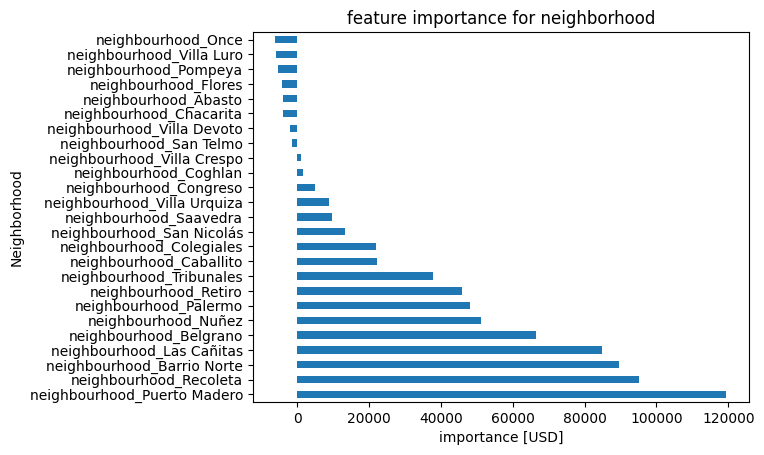

In [78]:
feat_imp.sort_values(ascending=False).head(25).plot(kind='barh')
plt.xlabel('importance [USD]')
plt.ylabel('Neighborhood')
plt.title('feature importance for neighborhood');